# Praca domowa 5
## Hotel booking 

Karolina Seweryn


Zbudowano trzy typy modeli opartych o drzewa decyzyjne przewidujace ceny doby hotelowej w hotelach w Portugali. Modele:

* Random Forest,
* XGBoost,
* LightGBM.

Poniższe wykresy prezentują wykresy `feature_importance` wyliczonej na podstawie permutacji wartości zmiennych. W każdym przypadku dokonano 15 iteracji algorytmu permutującego zmienne i na tej postawie narysowano wykresy skrzynkowe.

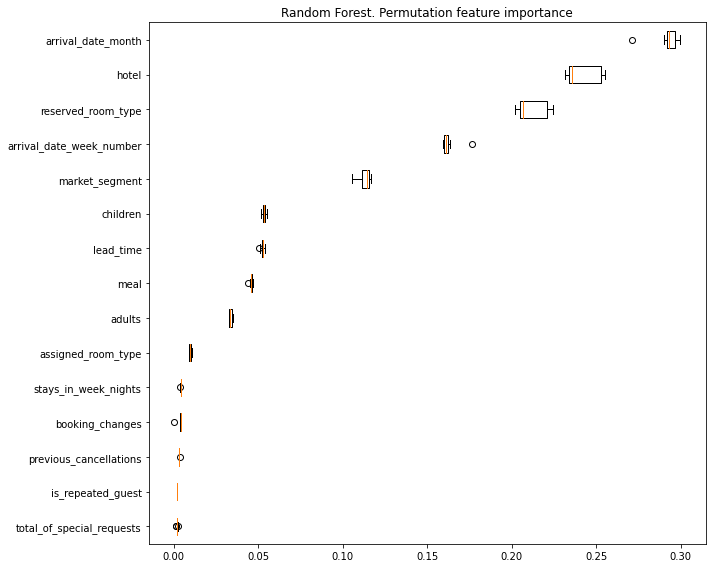

In [11]:
plot_feature_importance(rf, X_train, y_train, n_repeats=15, n_jobs=6, title="Random Forest. Permutation feature importance")

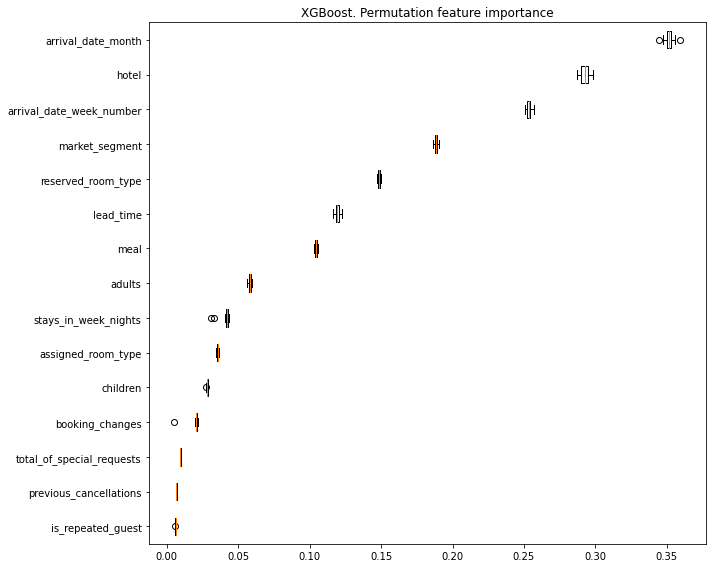

In [12]:
plot_feature_importance(xgb, X_train, y_train, n_repeats=15, n_jobs=6, title="XGBoost. Permutation feature importance")

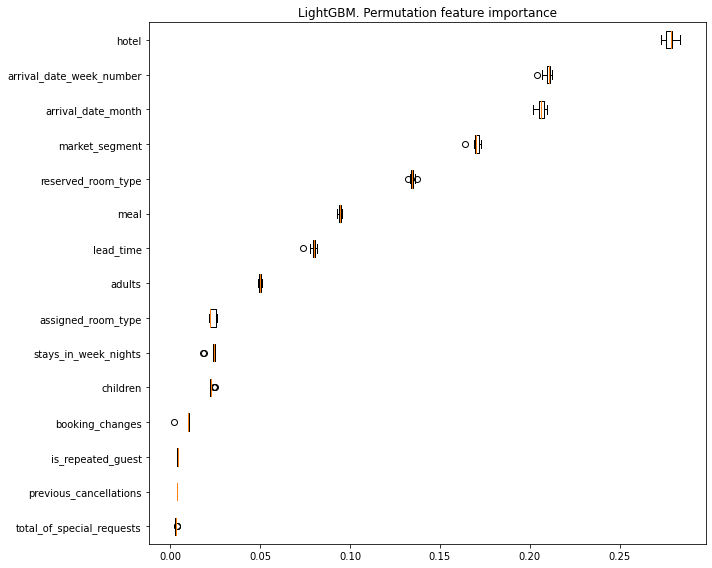

In [13]:
plot_feature_importance(lgbm, X_train, y_train, n_repeats=15, n_jobs=6, title="LightGBM. Permutation feature importance")

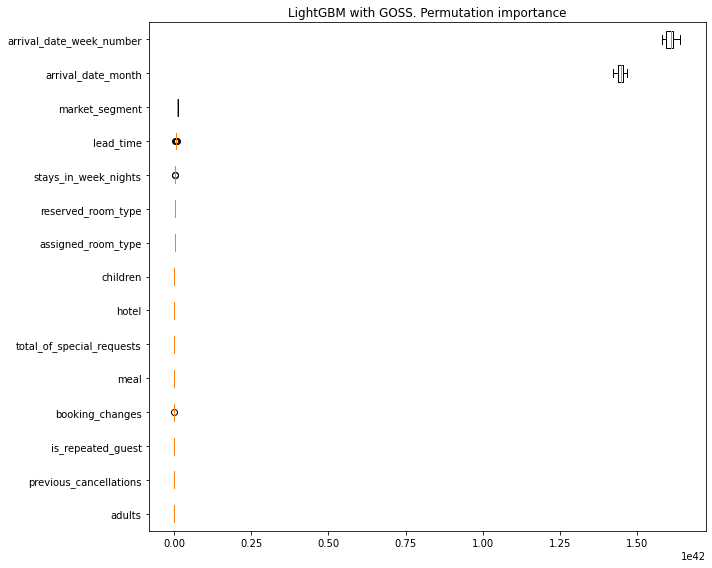

In [14]:
plot_feature_importance(lgbm2, X_train, y_train, n_repeats=15, n_jobs=6, title="LightGBM with GOSS. Permutation importance")

### Analiza wyników

Układ ważności zmiennych według `feature_importance` wyznaczono na podstawie permutacji wartości zmiennych. 
W przypadku pierwszych trzech modeli (RF, XGBoost i LightGBM z domyślnymi parametrami) na pierwszych 5 miejscach znajdują się te same zmienne tylko w różnej kolejności. Na pierwszych dwóch pozycjach znajdują się zmienne `arrival_date_month` (miesiąc przyjazdu) i `hotel` (informacja czy jest to hotel w środku miasta czy resort). Cena hoteli różnie rozkłada się w trakcie roku, co potwierdza intuicyjną ważność zmiennej mówiącej o miesiącu przyjazdu do hotelu. Ważną zmienną według trzech modeli jest także typ zarezerwowanego pokoju, co również jest intuicyjne. 

Miejsca w rankingu pozostałych zmiennych różnią się w wybranych modelach. W przypadku modelu `Random Forest` znajdują się tam liczba dzieci i dorosłcyh, liczba dni pomiędzy rezerwacją a przyjazdem (`lead_time`) i rodzaj zamówionych posiłków. W modelu XGBoost również te zmienne są ważne, dodatkowo wysoką ważność mają także zmienne `booking_changes` i `stay_in_week_nights`. Pierwza mówi o tym czy nastąpiły jakieś zmiany w rezerwacji, a druga ile nocy od poniedziałku do piątku zawiera rezerwacja. W przypadku `LightGBM` zmienne układają się w rankingu bardzo podobnie do modelu `XGBoost`. Może to wynikać z faktu, że w modelu LightGBM zastosowano domyślne parametry, w których  *boosting_type='gbdt'*, jest to podobny model do XGBoosta i nie jest algorytmem LightGBM zaproponowanym przez Microsoft. Dlatego dodatkowo nauczono jeszcze jeden model z pakietu lightgbm z parametrem *boosting_type='goss'*. Co ciekawe ważność zmiennych wyszła zupełnie inaczej niż w przypadku modelu `LGBMRegressor` z domyślnymi parametrami. W przypadku "prawdziwego" modelu lightgbm ważne zmienne to tylko `arrival_date_week_number` i `arrival_date_month`, pozostałe mają wskaźnik `feature_importance` bliski 0.

### Załącznik

Poniżej znajdują się kody z rozwiązaniem pracy domowej.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from lime.lime_tabular import LimeTabularExplainer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ceteris_paribus.explainer import explain
from ceteris_paribus.plots.plots import plot_notebook, plot
from ceteris_paribus.profiles import individual_variable_profile


def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values.
    
    le: a fitted sklearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res


def explain_model(model, X_train, X_test, y_train, y_test, obs, selected_variables, columns):
    explainer = explain(model, columns, X_train, y_train)
    cp = individual_variable_profile(explainer, X_train.loc[obs], y_train.loc[obs])
    plot_notebook(cp, selected_variables=selected_variables, print_observations=False)
    
def plot_feature_importance(model, X, y, n_repeats=10, n_jobs=1, title="Permutation Importances"):
    result = permutation_importance(model, X, y, n_repeats=n_repeats,
                                random_state=42, n_jobs=n_jobs)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title(title)
    fig.tight_layout()
    plt.show()


In [8]:
df = pd.read_csv("./data/hotel_bookings.csv")

month_name_to_num = {name: num for num, name in enumerate(calendar.month_name) if num}
df['arrival_date_month'] = [month_name_to_num[x] for x in df['arrival_date_month']]
df["arrival_weekday"] = [calendar.weekday(df.loc[i, 'arrival_date_year'], df.loc[i, 'arrival_date_month'], df.loc[i, 'arrival_date_day_of_month']) for i in df.index]

df = df.drop(["arrival_date_year", "country", "agent", "company", "reservation_status_date", "reservation_status", "is_canceled"], axis=1)
feature_type = df.dtypes
object_features = [i for i in feature_type.index if feature_type[i] == 'object']

for feat in object_features:
    le = LabelEncoder()
    df[feat] = le.fit_transform(df[feat]) 
    integerMapping = get_integer_mapping(le)
    print(feat)
    print(integerMapping)
    
X = df.drop('adr', axis=1)
X = X.fillna(value=0)
y = df['adr']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


hotel
{'City Hotel': 0, 'Resort Hotel': 1}
meal
{'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4}
market_segment
{'Aviation': 0, 'Complementary': 1, 'Corporate': 2, 'Direct': 3, 'Groups': 4, 'Offline TA/TO': 5, 'Online TA': 6, 'Undefined': 7}
distribution_channel
{'Corporate': 0, 'Direct': 1, 'GDS': 2, 'TA/TO': 3, 'Undefined': 4}
reserved_room_type
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'L': 8, 'P': 9}
assigned_room_type
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'P': 11}
deposit_type
{'No Deposit': 0, 'Non Refund': 1, 'Refundable': 2}
customer_type
{'Contract': 0, 'Group': 1, 'Transient': 2, 'Transient-Party': 3}


In [9]:

# Model 1
rf_sel = RandomForestRegressor(max_depth=5, n_estimators=100)
selector = RFE(rf_sel, 15, step=2)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)

X_train, X_test = X_train.iloc[:,cols], X_test.iloc[:,cols]

rf = RandomForestRegressor(max_depth=8, n_estimators=500)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Model 2
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)


In [10]:
# Model 3
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

y_pred_train_xgb = lgbm.predict(X_train)
y_pred_test_xgb = lgbm.predict(X_test)

# Model 4
lgbm2 = LGBMRegressor(boosting_type='goss')
lgbm2.fit(X_train, y_train)

y_pred_train_xgb = lgbm2.predict(X_train)
y_pred_test_xgb = lgbm2.predict(X_test)